In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [ ]:
from einops import rearrange
import math
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from bliss.encoders.detection import DetectionEncoder
from bliss.catalog import TileCatalog, FullCatalog

import sep_pjw as sep

In [ ]:
def asinh_map(x, q=0.01, stretch=1, minimum=0):
    return np.arcsinh(q * (x - minimum) / stretch) / q

In [ ]:
device = torch.device("cuda:0")
TILE_SLEN = 4
PTILE_SLEN = 52
BP = 24

In [ ]:
# model
detection = DetectionEncoder().to(device).eval()
_ = detection.load_state_dict(
    torch.load(f"../../models/detection_42_42.pt", map_location=device, weights_only=True)
)
detection = detection.requires_grad_(False)

In [ ]:
# data
from bliss.datasets.io import load_dataset_npz

test_ds = load_dataset_npz("../../data/datasets/test_ds_42.npz")
test_ds.keys()

dict_keys(['images', 'noiseless', 'uncentered_sources', 'centered_sources', 'paddings', 'fluxes', 'star_bools', 'plocs', 'n_sources', 'galaxy_params', 'star_fluxes', 'galaxy_bools'])

In [ ]:
# use 1000 images for now to speedup iteration time
test_ds_sample = {p: q[:1000] for p, q in test_ds.items()}
images = test_ds_sample["images"]
images.shape

torch.Size([1000, 1, 88, 88])

In [ ]:
# obtain outputs from all images
from bliss.render_tiles import make_ptile_loader

ptile_loader = make_ptile_loader(images, device)

In [ ]:
# process batches of images
nth = (images.shape[2] - 2 * BP) // TILE_SLEN
ntw = (images.shape[3] - 2 * BP) // TILE_SLEN
n1 = math.ceil(images.shape[0] / 10)
n2 = math.ceil(nth / 15)
total_n_ptiles = n1 * n2

tiled_params_list = []
for flat_ptiles in tqdm(ptile_loader, total=total_n_ptiles):

    n_source_probs, locs_mean, locs_sd_raw = detection.encode_tiled(flat_ptiles)

    _tiled_params = {
        "n_source_probs": n_source_probs.cpu(),
        "locs_mean": locs_mean.cpu(),
        "locs_sd": locs_sd_raw.cpu(),
    }
    tiled_params_list.append(_tiled_params)

100%|██████████| 100/100 [00:03<00:00, 27.90it/s]


In [ ]:
from bliss.encoders.encoder import _collate

tiled_params = _collate(tiled_params_list)

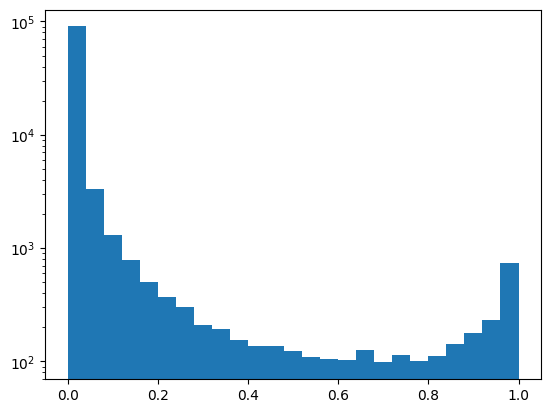

In [ ]:
plt.hist(tiled_params["n_source_probs"].cpu().numpy(), bins=25)

In [ ]:
# get full catalogs for different thresholds
thresholds = [0.2, 0.4, 0.5, 0.6, 0.75]
pred_cats = []

for thres in thresholds:
    n_source_probs = tiled_params["n_source_probs"]
    n_sources = n_source_probs.ge(thres).long()
    tiled_is_on = rearrange(n_source_probs.ge(thres).float(), "n -> n 1")

    locs = tiled_params["locs_mean"] * tiled_is_on
    locs_sd = tiled_params["locs_sd"] * tiled_is_on

    tile_cat = TileCatalog.from_flat_dict(
        TILE_SLEN,
        nth,
        ntw,
        {
            "n_sources": n_sources,
            "locs": locs,
            "locs_sd": locs_sd,
            "n_source_probs": n_source_probs.reshape(-1, 1),
        },
    )

    pred_cats.append(tile_cat.to_full_params())

In [ ]:
# get truth catalog
exclude = ("images", "uncentered_sources", "centered_sources", "noiseless", "paddings")
slen = images.shape[-1] - 2 * BP
true_cat_dict = {p: q for p, q in test_ds_sample.items() if p not in exclude}
truth = FullCatalog(slen, slen, true_cat_dict)

In [ ]:
catalog['x'].shape

(5,)

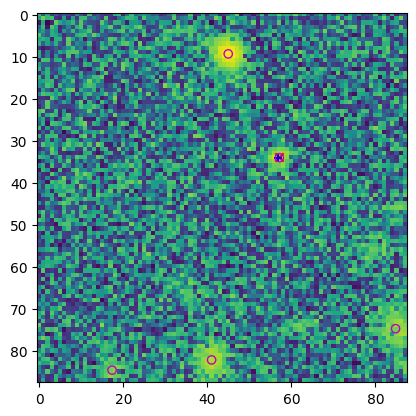

In [ ]:
# let's compare some images
idx = 332
idx2 = 2
x = images[idx, 0].numpy()
_image = asinh_map(x, q=0.01, stretch=1)

# sep 
bkg = sep.Background(x)
catalog = sep.extract(x, 1.5, err=bkg.globalrms, minarea=5)


n1 = truth.n_sources[idx].item()
n2 = pred_cats[idx2].n_sources[idx].item()

x1 = truth.plocs[idx, :, 1] - 0.5 + BP
y1 = truth.plocs[idx, :, 0] - 0.5 + BP

x2 = pred_cats[idx2].plocs[idx, :, 1] - 0.5 + BP
y2 = pred_cats[idx2].plocs[idx, :, 0] - 0.5 + BP

plt.imshow(_image)

for ii in range(n1):
    plt.scatter(x1[ii], y1[ii], marker="x", color="r")

for ii in range(n2):
    plt.scatter(x2[ii], y2[ii], marker="+", color="b")

plt.scatter(catalog['x'], catalog['y'], marker='o', color='m', facecolors='none')



# add grid 